![Colegio Bourbaki](./Images/Bourbaki.png)

### Modelo SARIMAX

**ARIMA** es un modelo de pronóstico para series temporales que combina tres componentes principales:

* **Autoregresivo (AR):** La relación entre una observación y un número de observaciones retrasadas.
* **Integrado (I):** Diferenciación de observaciones crudas para hacer la serie temporal estacionaria, es decir, para eliminar tendencia y estacionalidad.
* **Media Móvil (MA):** Dependencia entre una observación y un error residual móvil proveniente de un modelo de media móvil aplicado a observaciones retrasadas.

La notación ARIMA $(p, d, q)$ describe los componentes del modelo con:

* $p$: El número de términos autoregresivos.
* $d$: El grado de diferenciación.
* $q$: El número de términos de media móvil.

ARIMA es adecuado para series temporales que no tienen un patrón estacional claro o cuando la estacionalidad se ha eliminado previamente.

**SARIMAX** extiende el modelo ARIMA al incorporar componentes adicionales para manejar la estacionalidad y variables exógenas:

* **Componente Estacional(S):** Similar a la estructura ARIMA pero aplicada a la componente estacional de la serie temporal. Se describe con los parámetros estacionales (P, D, Q)m, donde P, D, y Q representan la autoregresión estacional, la diferenciación estacional, y la media móvil estacional, respectivamente, y m es el número de periodos en cada ciclo estacional.
* **Variables Exógenas (X):** Variables independientes que pueden influir en la serie temporal pero no son parte de la serie en sí. SARIMAX permite incorporar el efecto de estas variables exógenas en el modelo, mejorando la precisión del pronóstico cuando se dispone de información relevante externa.

La inclusión de componentes estacionales y variables exógenas hace que SARIMAX sea particularmente útil en situaciones donde la estacionalidad es pronunciada y/o se desea evaluar el impacto de variables externas en la serie temporal.

#### Contexto

Utilizaremos la producción de Petróleo y Gas de Argentina desde 2009-01 hasta 2023-12

#### Librerias

In [1]:
# Data Analysis
import pandas as pd

# Series Temporales
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.arima_model import ARIMA

# Prophet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

# Utils
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
from concurrent.futures import ProcessPoolExecutor
from scipy import stats
from tqdm import tqdm

In [2]:
import warnings

warnings.filterwarnings("ignore")

#### Funciones de ayuda

In [3]:
def p_value_adfuller(data):
    fuller_test = adfuller(data)
    print("P-value: ", fuller_test[1])
    if fuller_test[1] <= 0.05:
        print("Se rechaza la hipótesis nula, los datos son estacionarios")
    else:
        print("No se rechaza la hipóteis nula, los datos no son estacionarios")

In [4]:
def p_value_kpss(data):
    kpss_test = kpss(data)
    print("P-value: ", kpss_test[1])
    if kpss_test[1] <= 0.05:
        print("Se acepta la hipótesis nula, los datos son estacionarios")
    else:
        print("Se rechaza la hipóteis nula, los datos no son estacionarios")

In [5]:
# Function to train SARIMAX model and calculate AIC
def train_sarimax_model(params):
    parametros, parametros_s, data, column_name = params
    try:
        modelo = SARIMAX(
            data,
            order=parametros,
            seasonal_order=parametros_s,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = modelo.fit(disp=False)
        return (
            parametros,
            parametros_s,
            results.aic,
            column_name,
        )  # Include column_name in the result
    except Exception as e:
        return (
            parametros,
            parametros_s,
            float("inf"),
            column_name,
        )  # Include column_name in case of error

#### Carga de datos

In [6]:
df_oil = pd.read_csv("./Data/petroleo_diaria_pais.csv")
df_gas = pd.read_csv("./Data/gas_diaria_pais.csv")

In [7]:
df_oil.head()

,anio,mes,indice_tiempo,produccion_petroleo_promedio_dia_m3
0,2009,1,2009-01,97924.5991
1,2009,2,2009-02,100044.0659
2,2009,3,2009-03,99329.5204
3,2009,4,2009-04,98880.3859
4,2009,5,2009-05,98151.9991


In [8]:
df_gas.head()

,anio,mes,indice_tiempo,produccion_gas_promedio_dia_mm3
0,2009,1,2009-01,131223.0108
1,2009,2,2009-02,132833.2683
2,2009,3,2009-03,135361.2048
3,2009,4,2009-04,135493.2462
4,2009,5,2009-05,135374.4330


In [9]:
df = pd.merge(df_oil, df_gas)

In [10]:
df

,anio,mes,indice_tiempo,produccion_petroleo_promedio_dia_m3,produccion_gas_promedio_dia_mm3
0,2009,1,2009-01,97924.5991,131223.0108
1,2009,2,2009-02,100044.0659,132833.2683
2,2009,3,2009-03,99329.5204,135361.2048
3,2009,4,2009-04,98880.3859,135493.2462
4,2009,5,2009-05,98151.9991,135374.4330
...,...,...,...,...,...
175,2023,8,2023-08,98899.7214,144374.8508
176,2023,9,2023-09,101249.5925,143185.6279
177,2023,10,2023-10,103903.3087,125936.3690
178,2023,11,2023-11,105964.1426,126286.3582


In [11]:
df["Date"] = pd.to_datetime(df["indice_tiempo"])
df = df.set_index("Date")

In [12]:
df["produccion_petroleo_promedio_dia_km3"] = (
    df["produccion_petroleo_promedio_dia_m3"] / 1000
)
df["produccion_gas_promedio_dia_Mm3"] = df["produccion_gas_promedio_dia_mm3"] / 1000

In [13]:
df["produccion_petroleo_promedio_dia_km3"]

Date
2009-01-01     97.924599
2009-02-01    100.044066
2009-03-01     99.329520
2009-04-01     98.880386
2009-05-01     98.151999
                 ...    
2023-08-01     98.899721
2023-09-01    101.249593
2023-10-01    103.903309
2023-11-01    105.964143
2023-12-01    107.396217
Name: produccion_petroleo_promedio_dia_km3, Length: 180, dtype: float64

Revisamos si las fechas están ordenadas:

In [14]:
df.index.is_monotonic_increasing

True

Para algunas funciones de ST es importante indicar la frecuencia de nuestros datos:

In [15]:
df.index.freq = df.index.inferred_freq
df.index

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Date', length=180, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

#### Exploración y Visualización de la Serie Temporal

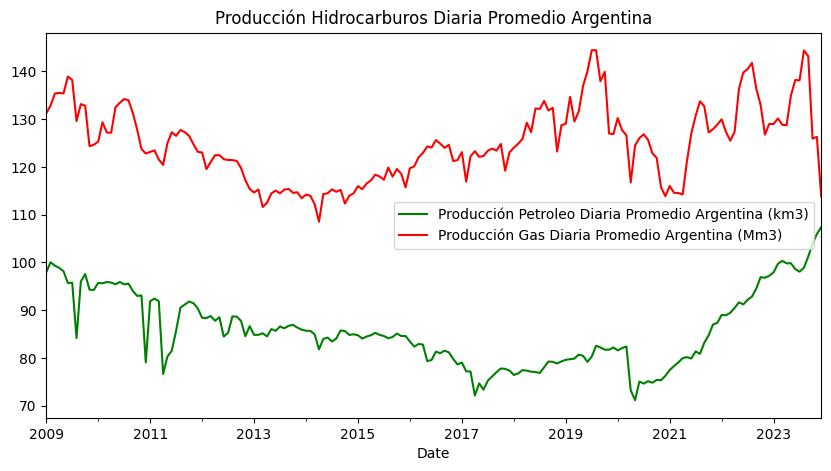

In [16]:
df["produccion_petroleo_promedio_dia_km3"].plot(
    figsize=(10, 5),
    title="Producción Hidrocarburos Diaria Promedio Argentina",
    color="green",
    label="Producción Petroleo Diaria Promedio Argentina (km3)",
)
df["produccion_gas_promedio_dia_Mm3"].plot(
    figsize=(10, 5), color="red", label="Producción Gas Diaria Promedio Argentina (Mm3)"
)
plt.legend()
plt.show()

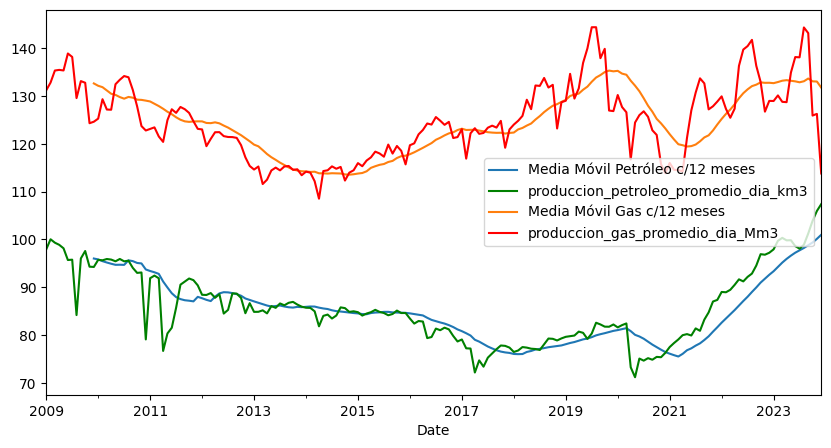

In [17]:
df["produccion_petroleo_promedio_dia_km3"].rolling(12).mean().plot(
    figsize=(10, 5), label="Media Móvil Petróleo c/12 meses"
)
df["produccion_petroleo_promedio_dia_km3"].plot(color="green")
df["produccion_gas_promedio_dia_Mm3"].rolling(12).mean().plot(
    figsize=(10, 5), label="Media Móvil Gas c/12 meses"
)
df["produccion_gas_promedio_dia_Mm3"].plot(color="red")
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

**Tendencia:**

La tendencia es un componente de la serie temporal que muestra un patrón persistente y de largo plazo, generalmente hacia arriba o hacia abajo, indicando un aumento o disminución en los datos a lo largo del tiempo. No tiene que ser lineal necesariamente; también puede ser exponencial o de cualquier otra forma que muestre una dirección consistente a lo largo de un período extenso. En SARIMAX, la parte "Integrada" (I) ayuda a manejar y estabilizar la tendencia en los datos, haciendo la serie estacionaria mediante diferenciación, lo cual es esencial para aplicar los componentes AR y MA.

**Estacionaridad:**

La estacionaridad se refiere a patrones o ciclos que se repiten a intervalos regulares dentro de la serie temporal, como diariamente, mensualmente, anualmente, etc. Estos patrones son predecibles y se atribuyen a factores estacionales, como el clima, los hábitos de compra, las festividades, entre otros. La componente "Seasonal" en SARIMAX modela explícitamente esta estacionalidad utilizando términos autoregresivos y de media móvil que se aplican a los ciclos estacionales de los datos, permitiendo que el modelo ajuste y prediga efectivamente estas variaciones periódicas.

**Residuos:**

Los residuos, en el contexto de modelado de series temporales, son la diferencia entre los valores observados y los valores ajustados (o predichos) por el modelo. En un modelo bien ajustado, los residuos deberían ser aleatorios y exhibir propiedades de ruido blanco, lo que significa que no tienen patrones predecibles, no están correlacionados y tienen una media constante cercana a cero. Los residuos representan la parte de la serie temporal que el modelo no puede explicar, y su análisis es crucial para evaluar la adecuación del modelo. Si los residuos muestran patrones no aleatorios o estacionalidad, esto sugiere que el modelo no ha capturado completamente toda la estructura de los datos, indicando la necesidad de revisar y posiblemente mejorar el modelo.


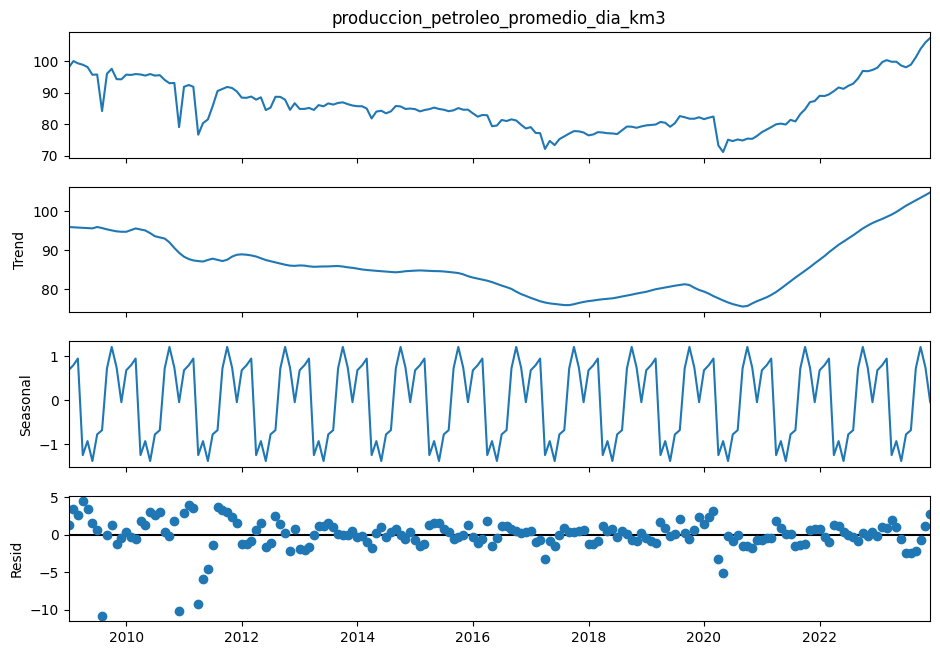

In [18]:
decomp_oil = seasonal_decompose(
    df["produccion_petroleo_promedio_dia_km3"], period=12, extrapolate_trend="freq"
)
fig = decomp_oil.plot()
fig.set_size_inches(10, 7)

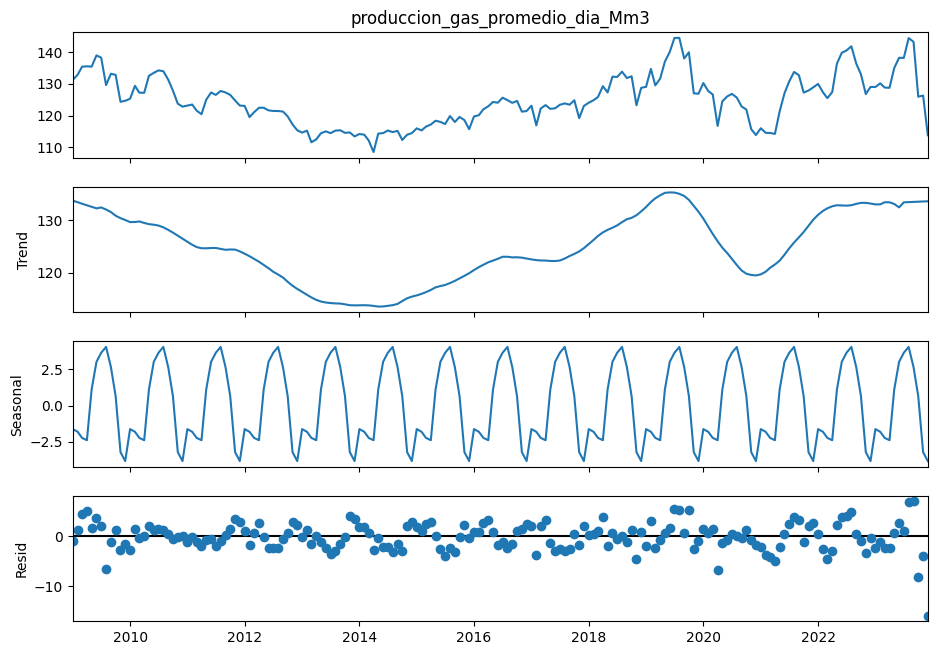

In [19]:
decomp_gas = seasonal_decompose(
    df["produccion_gas_promedio_dia_Mm3"], period=12, extrapolate_trend="freq"
)
fig = decomp_gas.plot()
fig.set_size_inches(10, 7)

#### Estacionaridad

Test de DF:

El test de Dickey-Fuller, específicamente el test de Dickey-Fuller Aumentado (ADF, por sus siglas en inglés Augmented Dickey-Fuller), es una prueba estadística utilizada para determinar si una serie temporal es estacionaria o no, enfocándose en la presencia de una raíz unitaria. Una serie temporal es estacionaria si sus propiedades estadísticas, como la media y la varianza, son constantes a lo largo del tiempo. La estacionalidad es una propiedad deseada en muchos modelos de series temporales porque facilita la predicción de futuros valores.

El test de Dickey-Fuller Aumentado verifica la hipótesis nula $(H_0​)$ de que una serie temporal tiene una raíz unitaria, lo que indica que no es estacionaria. Una raíz unitaria significa que la serie temporal puede ser representada por un proceso autorregresivo que tiene uno o más coeficientes igual a uno, lo cual es indicativo de un patrón persistente que no retorna a una media a largo plazo.

**Hipótesis del Test:**

* Hipótesis Nula $(H_0​)$: La serie temporal tiene una raíz unitaria (no es estacionaria).
* Hipótesis Alternativa $(H_1​)$: La serie temporal no tiene una raíz unitaria (es estacionaria).

**Interpretación del Test:**

La decisión de rechazar o no la hipótesis nula se basa en el valor p del test. Si el valor p es menor que un nivel de significancia predefinido (por ejemplo, 0.05), entonces se rechaza la hipótesis nula en favor de la hipótesis alternativa, sugiriendo que la serie temporal es estacionaria.

El test de Dickey-Fuller Aumentado es una herramienta esencial en el análisis de series temporales, especialmente antes de ajustar modelos como ARIMA, donde la estacionariedad de la serie es un requisito. Identificar y corregir la no estacionariedad (por ejemplo, mediante diferenciación) es un paso crítico en el proceso de modelado de series temporales.

**Limitaciones:**

Aunque el test ADF es ampliamente utilizado, tiene algunas limitaciones, como su sensibilidad al número de retrasos incluidos en el modelo y su tendencia a no detectar estacionariedad en presencia de cambios estructurales en la serie temporal. Por estas razones, a menudo se utiliza en conjunto con otras pruebas y análisis gráficos para una evaluación más completa de la estacionariedad.

Test de KPSS:

El KPSS es otra prueba para comprobar la estacionariedad de una serie temporal. Las hipótesis nula y alternativa de la prueba KPSS son opuestas a las de la prueba ADF.

* Hipótesis nula: El proceso es estacionario en cuanto a la tendencia.

* Hipótesis alternativa: La serie tiene una raíz unitaria (la serie no es estacionaria).

Primero, veamos el clase de la serie temporal del petróleo:

In [20]:
p_value_adfuller(df["produccion_petroleo_promedio_dia_km3"])

P-value:  0.8599134312425288
No se rechaza la hipóteis nula, los datos no son estacionarios


In [21]:
p_value_kpss(df["produccion_petroleo_promedio_dia_km3"])

P-value:  0.04765982896769343
Se acepta la hipótesis nula, los datos son estacionarios


Como los datos no son estacionarios por medio de los 2 tests, vamos a hacer un shift de una unidad:

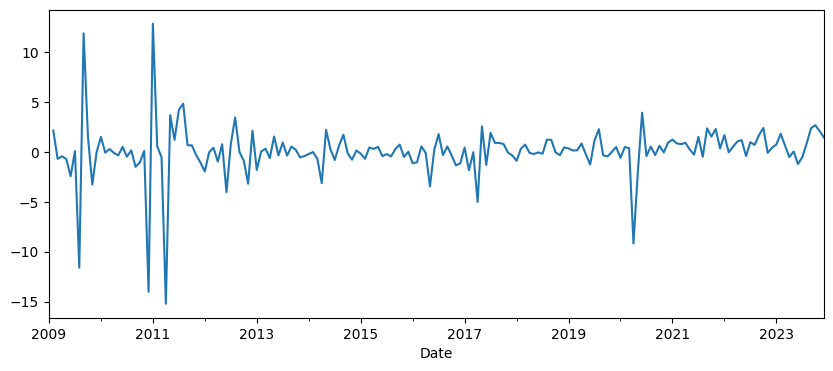

In [22]:
df["1a_diffoil"] = df["produccion_petroleo_promedio_dia_km3"] - df[
    "produccion_petroleo_promedio_dia_km3"
].shift(1)
df["1a_diffoil"].plot(figsize=(10, 4))
plt.show()

In [23]:
p_value_adfuller(df["1a_diffoil"].dropna())

P-value:  1.5134553510520321e-18
Se rechaza la hipótesis nula, los datos son estacionarios


In [24]:
p_value_kpss(df["1a_diffoil"].dropna())

P-value:  0.045731863162562184
Se acepta la hipótesis nula, los datos son estacionarios


Veamos el caso de la serie del Gas:

In [25]:
p_value_adfuller(df["produccion_gas_promedio_dia_Mm3"])

P-value:  0.018403231446106012
Se rechaza la hipótesis nula, los datos son estacionarios


In [26]:
p_value_kpss(df["produccion_gas_promedio_dia_Mm3"])

P-value:  0.04964269790729427
Se acepta la hipótesis nula, los datos son estacionarios


Los datos son estacionarios.

#### ACF y PACF

Para el petróleo:

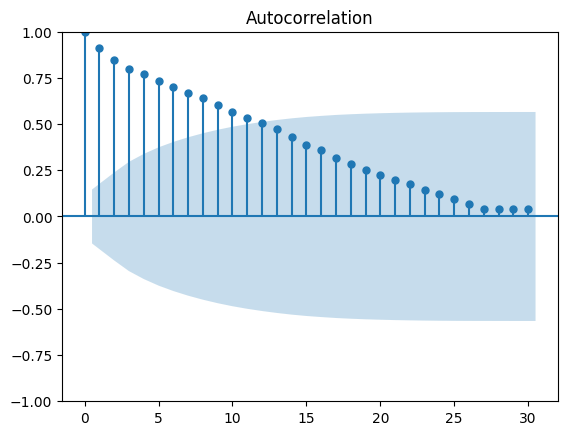

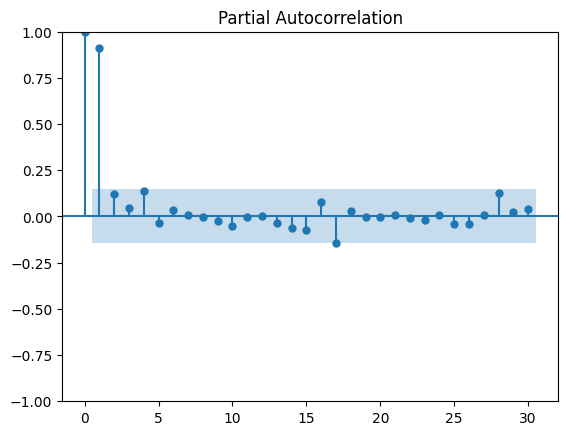

In [27]:
plot_acf(df["produccion_petroleo_promedio_dia_km3"], lags=30)
plot_pacf(df["produccion_petroleo_promedio_dia_km3"], lags=30)
plt.show()

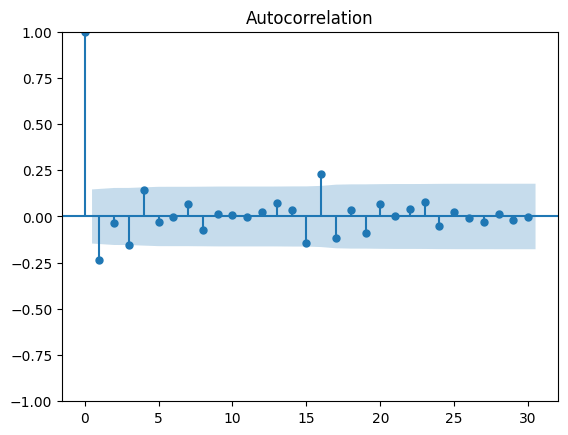

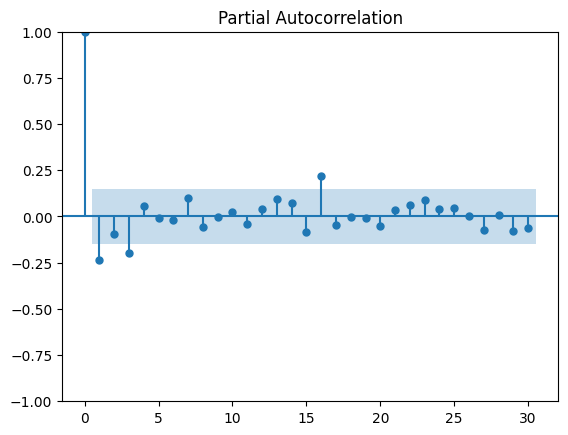

In [28]:
plot_acf(df["1a_diffoil"].dropna(), lags=30)
plot_pacf(df["1a_diffoil"].dropna(), lags=30)
plt.show()

Para el gas:

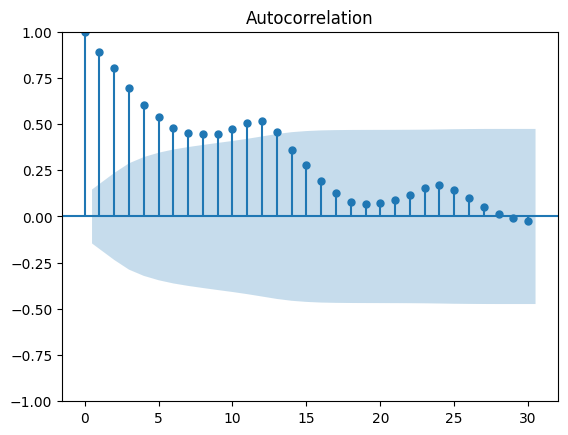

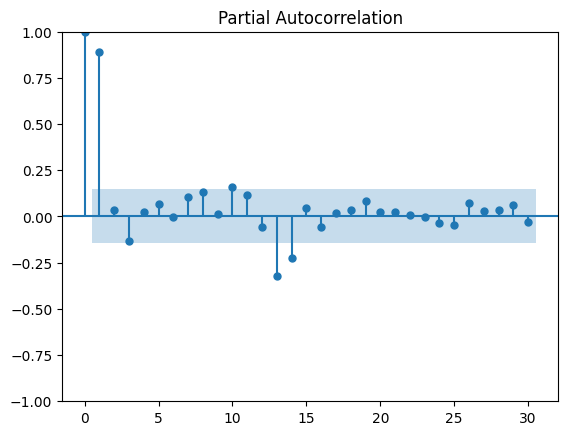

In [29]:
plot_acf(df["produccion_gas_promedio_dia_Mm3"], lags=30)
plot_pacf(df["produccion_gas_promedio_dia_Mm3"], lags=30)
plt.show()

#### Construcción del modelo SARIMAx

Pueden revisar la documentación de statsmodels sobre Time Series Analysis, es muy interesante: https://www.statsmodels.org/stable/examples/index.html#time-series-analysis

In [30]:
train_oil = df.loc[:"2022-12-1", "produccion_petroleo_promedio_dia_km3"]
test_oil = df.loc["2023-1-1":, "produccion_petroleo_promedio_dia_km3"]
train_gas = df.loc[:"2022-12-1", "produccion_gas_promedio_dia_Mm3"]
test_gas = df.loc["2023-1-1":, "produccion_gas_promedio_dia_Mm3"]

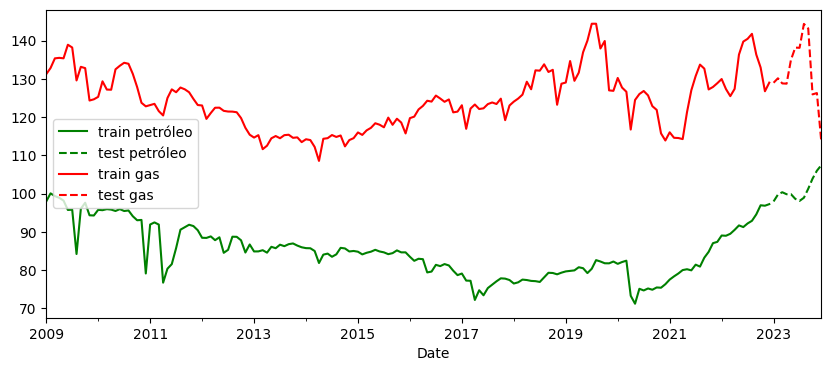

In [31]:
train_oil.plot(label="train petróleo", figsize=(10, 4), color="green")
test_oil.plot(label="test petróleo", figsize=(10, 4), color="green", linestyle="--")
train_gas.plot(label="train gas", figsize=(10, 4), color="red")
test_gas.plot(label="test gas", figsize=(10, 4), color="red", linestyle="--")
plt.legend()
plt.show()

In [32]:
len(train_oil), len(test_oil)

(168, 12)

In [33]:
print(
    f"Porcentaje de datos de prueba para el petróleo: {100*len(test_oil)/(len(train_oil)+len(test_oil)):.2f}"
)
print(
    f"Porcentaje de datos de prueba para el gas: {100*len(test_gas)/(len(train_gas)+len(test_gas)):.2f}"
)

Porcentaje de datos de prueba para el petróleo: 6.67
Porcentaje de datos de prueba para el gas: 6.67


Vamos a generar una combinación de los parámetros de los modelos SARIMAX:

In [34]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [35]:
p = d = q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

El criterio de información de Akaike (AIC, por sus siglas en inglés, Akaike Information Criterion) es una medida utilizada en estadística para la selección de modelos. En el contexto del código que proporcionaste, donde se ajustan modelos SARIMAX a series temporales, el AIC se utiliza para comparar diferentes modelos entre sí y seleccionar el mejor.

El AIC es un criterio basado en la teoría de la información que busca encontrar el modelo que mejor explica los datos con la menor cantidad de parámetros. Proporciona un balance entre la complejidad del modelo (número de parámetros) y su ajuste a los datos. Un modelo que se ajusta perfectamente pero que usa demasiados parámetros puede capturar el ruido en lugar de la señal (overfitting), mientras que un modelo con pocos parámetros puede no capturar toda la estructura de los datos (underfitting).

Interpretación del AIC

* Valor Absoluto del AIC: Por sí solo, el valor absoluto del AIC no tiene un significado inherente. Lo importante es la diferencia relativa en los valores de AIC entre diferentes modelos.
* Comparación de Modelos: Entre dos o más modelos, el que tiene el menor AIC se considera el "mejor", en el sentido de que tiene un equilibrio óptimo entre ajuste y complejidad.
* Diferencia de AIC: Una diferencia de AIC de 2 o más se considera sustancial. Sin embargo, cuando las diferencias son pequeñas (por ejemplo, menos de 2), puede no haber una preferencia clara entre los modelos comparados.

Aplicación en SARIMAX

En el ajuste de modelos SARIMAX a datos de series temporales, el AIC se utiliza para elegir entre diferentes combinaciones de órdenes autoregresivas (AR), integradas (I), medias móviles (MA), y componentes estacionales. Seleccionar el modelo con el AIC más bajo ayuda a prevenir tanto la sobreadaptación como la subadaptación, facilitando la elección de un modelo que generalice bien a nuevos datos.

In [36]:
# UTILIZAR ESTE CODIGO EN CASO DE TENER PROBLEMAS CON LA CLASE POOLPROCESSING, TARDA EL DOBLE.

# %%time

# aic_modelos_oil = {}
# aic_modelos_gas = {}

# # Loop para iterar a través de combinaciones de parámetros.
# for parametros in pdq:
#     for parametros_s in seasonal_pdq:
#         try:
#             modelo_oil = SARIMAX(df.loc[:'2023-1-1', 'produccion_petroleo_promedio_dia_km3'],
#                              order=parametros,
#                              seasonal_order=parametros_s,
#                              enforce_stationarity=False,
#                              enforce_invertibility=False)
#             results_oil = modelo_oil.fit(disp=False)  # Añadido disp=False para minimizar la salida durante el ajuste
#             aic_modelos_oil[(parametros, parametros_s)] = results_oil.aic
#             print(f'Petróleo: ARIMA{parametros}x{parametros_s} - AIC:{results_oil.aic}')
#         except Exception as e:
#             print(f'Error con ARIMA{parametros}x{parametros_s}: {e}')
#             continue
#         try:
#             modelo_gas = SARIMAX(df.loc[:'2023-1-1', 'produccion_gas_promedio_dia_Mm3'],
#                              order=parametros,
#                              seasonal_order=parametros_s,
#                              enforce_stationarity=False,
#                              enforce_invertibility=False)
#             results_gas = modelo_gas.fit(disp=False)
#             aic_modelos_gas[(parametros, parametros_s)] = results_gas.aic
#             print(f'Gas: ARIMA{parametros}x{parametros_s} - AIC:{results_gas.aic}')
#         except Exception as e:
#             print(f'Error con ARIMA{parametros}x{parametros_s}: {e}')
#             continue

Modelo Petróleo:  ((2, 1, 2), (2, 1, 2, 12))

AIC Petróleo:  500.4189061299926

Modelo Gas:  ((2, 0, 2), (2, 2, 2, 12))

AIC Gas:  606.9393688175638

Para el petróleo:

In [37]:
aic_modelos_oil = {((2, 1, 2), (2, 1, 2, 12)): 500.4189061299926}

In [38]:
aic_modelos_oil

{((2, 1, 2), (2, 1, 2, 12)): 500.4189061299926}

In [39]:
sarimax_oil = SARIMAX(
    train_oil,
    order=min(aic_modelos_oil, key=aic_modelos_oil.get)[0],
    seasonal_order=min(aic_modelos_oil, key=aic_modelos_oil.get)[1],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
resultados_oil = sarimax_oil.fit()
print(resultados_oil.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81921D+00    |proj g|=  2.52481D-01


 This problem is unconstrained.



At iterate    5    f=  1.50330D+00    |proj g|=  1.35056D-01

At iterate   10    f=  1.47125D+00    |proj g|=  1.59913D-02

At iterate   15    f=  1.46683D+00    |proj g|=  3.84456D-02

At iterate   20    f=  1.45939D+00    |proj g|=  5.43256D-02

At iterate   25    f=  1.45454D+00    |proj g|=  2.60645D-02

At iterate   30    f=  1.44975D+00    |proj g|=  7.84466D-02

At iterate   35    f=  1.43702D+00    |proj g|=  3.32280D-02

At iterate   40    f=  1.43590D+00    |proj g|=  7.92905D-03

At iterate   45    f=  1.43577D+00    |proj g|=  3.92929D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     59   

In [40]:
resultados_oil.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                         
================================================================================================
Dep. Variable:     produccion_petroleo_promedio_dia_km3   No. Observations:                  168
Model:                   SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -241.209
Date:                                  Tue, 14 May 2024   AIC                            500.419
Time:                                          17:39:55   BIC                            526.087
Sample:                                      01-01-2009   HQIC                           510.848
                                           - 12-01-2022                                         
Covariance Type:                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9439      0.106      8.876      0.000       0.735       1.152
ar.L2         -0.5546      0.042    -13.184      0.000      -0.637      -0.472
ma.L1         -1.1626      0.130     -8.962      0.000      -1.417      -0.908
ma.L2          0.6895      0.078      8.848      0.000       0.537       0.842
ar.S.L12      -0.0594      0.097     -0.612      0.541      -0.250       0.131
ar.S.L24      -0.2091      0.053     -3.945      0.000      -0.313      -0.105
ma.S.L12      -0.8378      0.134     -6.256      0.000      -1.100      -0.575
ma.S.L24       0.2211      0.124      1.777      0.076      -0.023       0.465
sigma2         2.3862      0.203     11.726      0.000       1.987       2.785
===================================================================================
Ljung-Box (L1) (Q):                   1.69   Jarque-Bera (JB):               122.49
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -1.19
Prob(H) (two-sided):                  0.16   Kurtosis:                         7.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Gráficos diagnóstico:

**Gráfico de Residuos Estandarizados:** Muestra los residuos del modelo a lo largo del tiempo. Los residuos son las diferencias entre los valores observados y los valores predichos por el modelo. Este gráfico ayuda a evaluar si los residuos parecen ser aleatorios (sin patrones) y si tienen varianza constante a lo largo del tiempo, dos propiedades importantes para un buen modelo de series temporales.

**Histograma con Densidad Estimada:**
        
* Histograma (Hist): Representa la distribución de frecuencias de los residuos. En un buen modelo, esperaríamos que los residuos sigan aproximadamente una distribución normal centrada en cero.
* Estimación de Densidad Núcleo (KDE): Es una curva suave que estima la densidad de probabilidad de los residuos. Si se asemeja a la curva de la distribución normal (N(0,1)), sugiere que los residuos podrían ser normalmente distribuidos.
* N(0,1): Es la curva de la distribución normal estándar para comparación. Idealmente, el histograma y la KDE deben seguir de cerca esta línea si los residuos están normalmente distribuidos.

**Gráfico Q-Q Normal (Quantile-Quantile):** Compara los cuantiles de los residuos con los cuantiles de una distribución normal estándar. Si los puntos caen aproximadamente a lo largo de la línea roja (que representa la igualdad de cuantiles), sugiere que los residuos tienen una distribución normal. Las desviaciones de esta línea indican desviaciones de la normalidad.

**Correlograma:** Muestra la autocorrelación de los residuos en diferentes lags. En un modelo bien ajustado, esperaríamos que todas las autocorrelaciones estén cerca de cero y dentro de la banda de confianza azul (que representa el rango en el que se considerarían estadísticamente insignificantes). Esto indicaría que no hay autocorrelación significativa en los residuos y que el modelo ha capturado adecuadamente la dependencia temporal en los datos.

En resumen, estos gráficos se utilizan para diagnosticar la calidad de un modelo estadístico, con un enfoque en la aleatoriedad, la distribución y la independencia de los residuos. Si los residuos no cumplen con estas condiciones, el modelo puede no ser apropiado o requerir modificaciones.

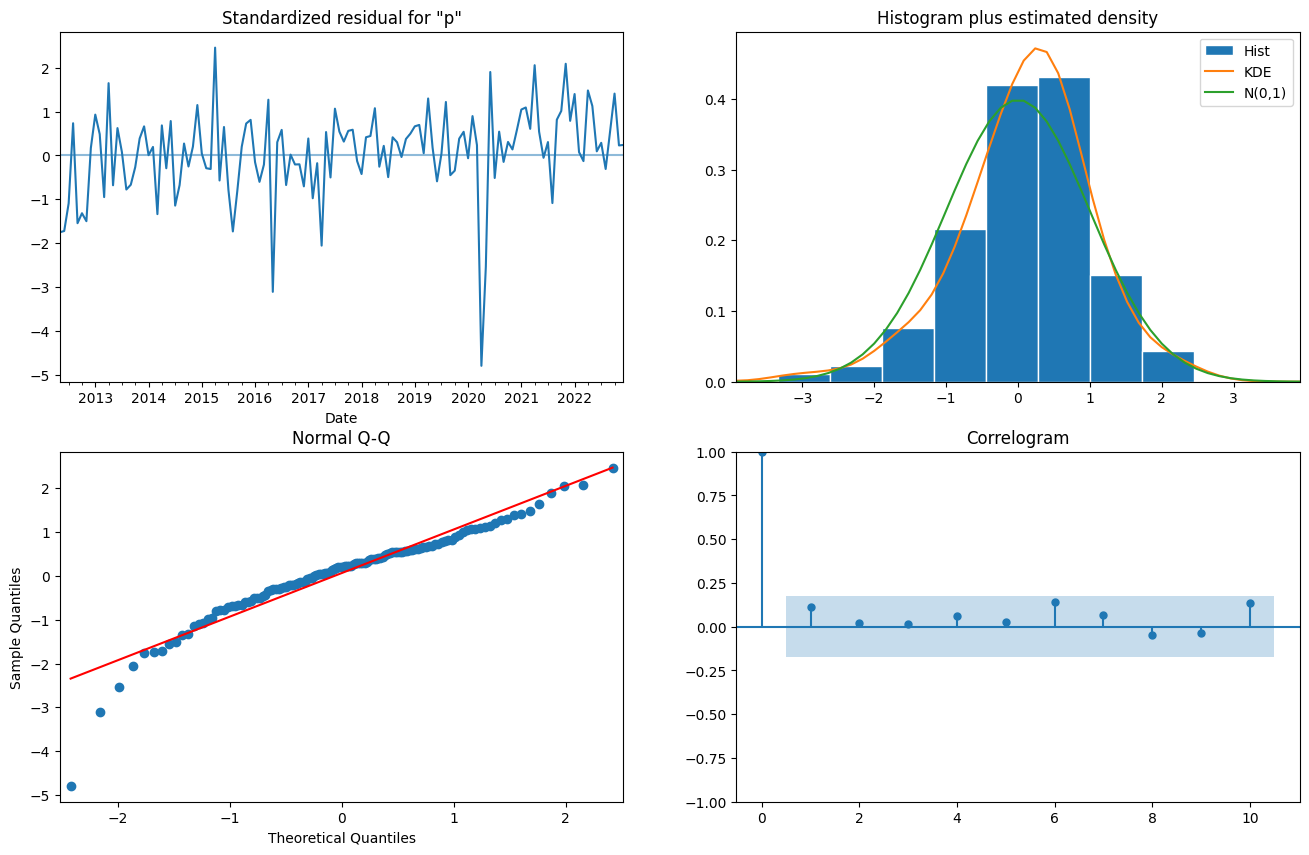

In [41]:
resultados_oil.plot_diagnostics(figsize=(16, 10))
plt.show()

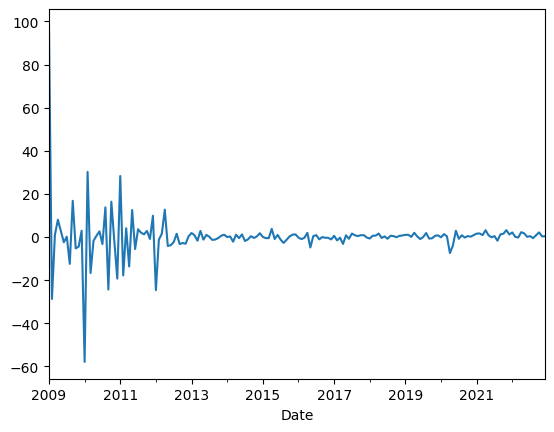

In [42]:
resultados_oil.resid.plot()
plt.show()

In [43]:
stats.normaltest(resultados_oil.resid)

NormaltestResult(statistic=175.56955735372287, pvalue=7.50853181934957e-39)

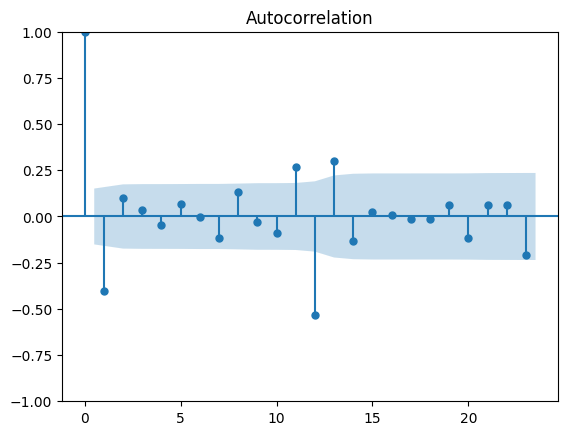

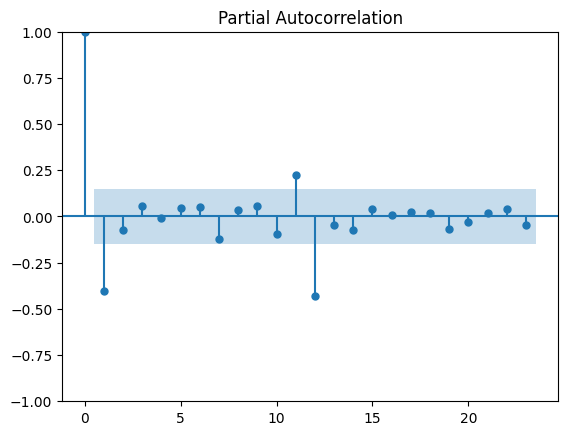

In [44]:
plot_acf(resultados_oil.resid)
plot_pacf(resultados_oil.resid)
plt.show()

Para el gas:

In [45]:
# Modelo Gas:  ((2, 0, 2), (2, 2, 2, 12))
# AIC Gas:  606.9393688175638
aic_modelos_gas = {((2, 0, 2), (2, 2, 2, 12)): 606.9393688175638}

In [46]:
sarimax_gas = SARIMAX(
    train_gas,
    order=min(aic_modelos_gas, key=aic_modelos_gas.get)[0],
    seasonal_order=min(aic_modelos_gas, key=aic_modelos_gas.get)[1],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
resultados_gas = sarimax_gas.fit()
print(resultados_gas.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07600D+00    |proj g|=  4.75005D-01


 This problem is unconstrained.



At iterate    5    f=  1.91316D+00    |proj g|=  1.27543D-01

At iterate   10    f=  1.81338D+00    |proj g|=  8.00948D-02

At iterate   15    f=  1.75904D+00    |proj g|=  3.44359D-01

At iterate   20    f=  1.75576D+00    |proj g|=  1.17912D-01

At iterate   25    f=  1.75404D+00    |proj g|=  1.01044D-01

At iterate   30    f=  1.75342D+00    |proj g|=  1.53339D-01

At iterate   35    f=  1.75292D+00    |proj g|=  6.57754D-03

At iterate   40    f=  1.75286D+00    |proj g|=  3.08731D-03

At iterate   45    f=  1.75281D+00    |proj g|=  2.57080D-03

At iterate   50    f=  1.75280D+00    |proj g|=  8.98773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [47]:
resultados_gas.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     produccion_gas_promedio_dia_Mm3   No. Observations:                  168
Model:              SARIMAX(2, 0, 2)x(2, 2, 2, 12)   Log Likelihood                -294.470
Date:                             Tue, 14 May 2024   AIC                            606.939
Time:                                     17:40:01   BIC                            631.799
Sample:                                 01-01-2009   HQIC                           617.032
                                      - 12-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8416      0.105     17.494      0.000       1.635       2.048
ar.L2         -0.8700      0.099     -8.827      0.000      -1.063      -0.677
ma.L1         -1.2540      0.109    -11.528      0.000      -1.467      -1.041
ma.L2          0.4785      0.089      5.380      0.000       0.304       0.653
ar.S.L12      -0.6176      0.247     -2.496      0.013      -1.103      -0.133
ar.S.L24      -0.3303      0.106     -3.117      0.002      -0.538      -0.123
ma.S.L12      -0.5455      8.838     -0.062      0.951     -17.867      16.776
ma.S.L24      -0.4586      3.817     -0.120      0.904      -7.939       7.022
sigma2         7.3673     64.728      0.114      0.909    -119.498     134.232
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.19
Prob(Q):                              0.91   Prob(JB):                         0.07
Heteroskedasticity (H):               2.32   Skew:                            -0.30
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

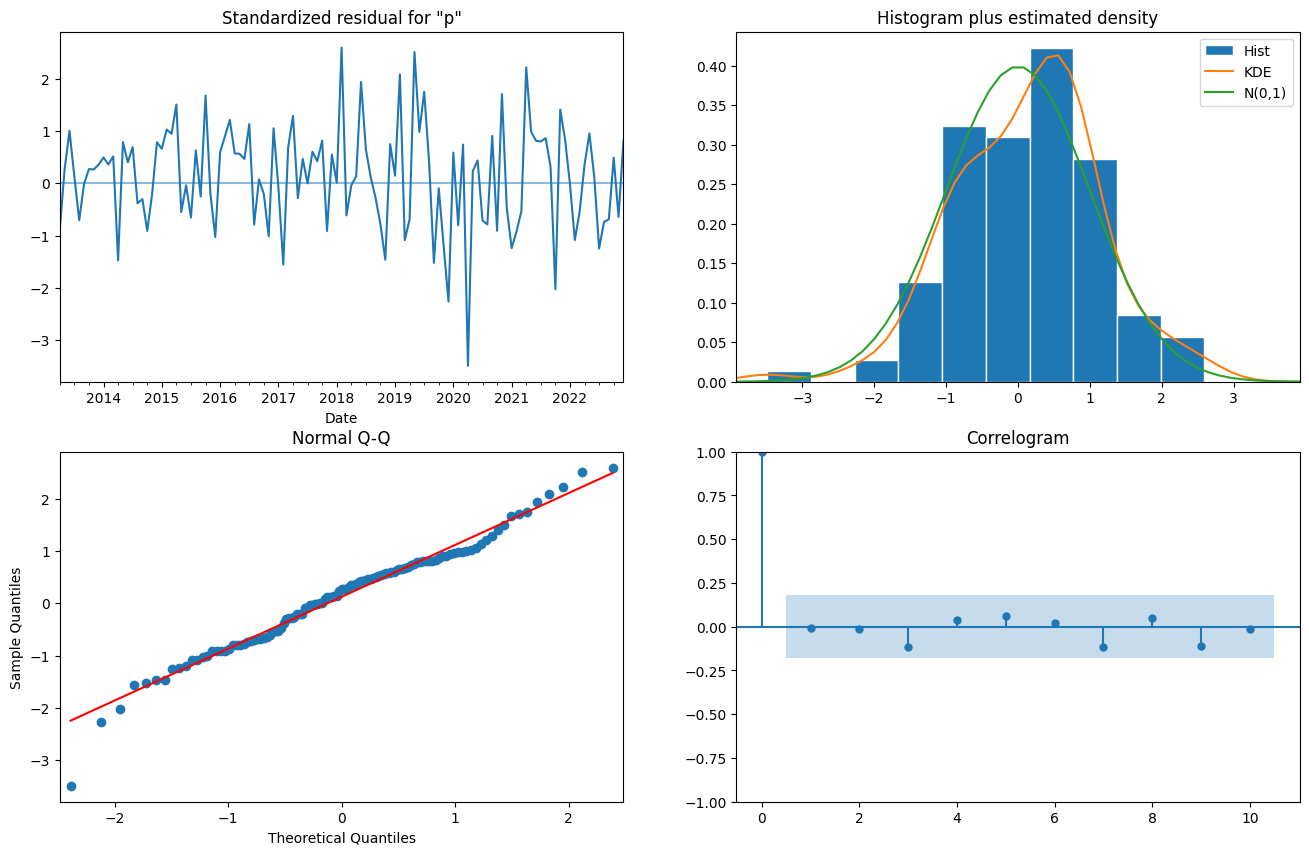

In [48]:
resultados_gas.plot_diagnostics(figsize=(16, 10))
plt.show()

In [49]:
stats.normaltest(resultados_gas.resid)

NormaltestResult(statistic=137.72543966091638, pvalue=1.2396548069419302e-30)

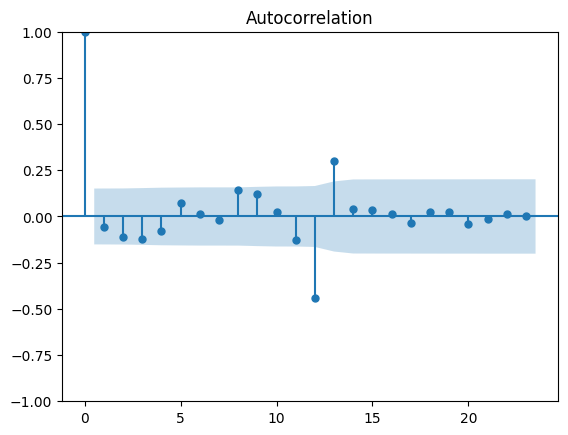

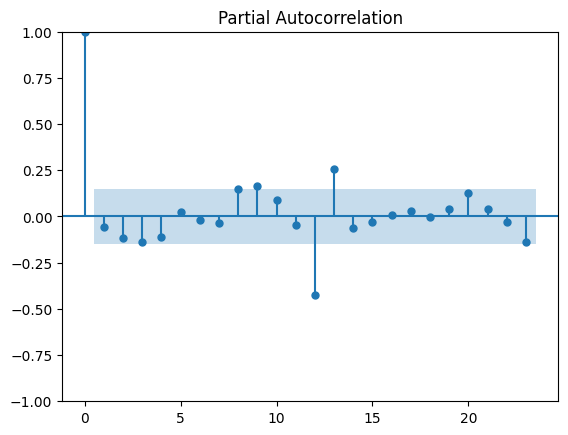

In [50]:
plot_acf(resultados_gas.resid)
plot_pacf(resultados_gas.resid)
plt.show()

#### Testing

In [51]:
pred_oil = resultados_oil.get_prediction(
    start=pd.to_datetime("2023-01-01"), end=pd.to_datetime("2026-01-01")
)
pred_IC_oil = pred_oil.conf_int()
pred_gas = resultados_gas.get_prediction(
    start=pd.to_datetime("2023-01-01"), end=pd.to_datetime("2026-01-01")
)
pred_IC_gas = pred_gas.conf_int()

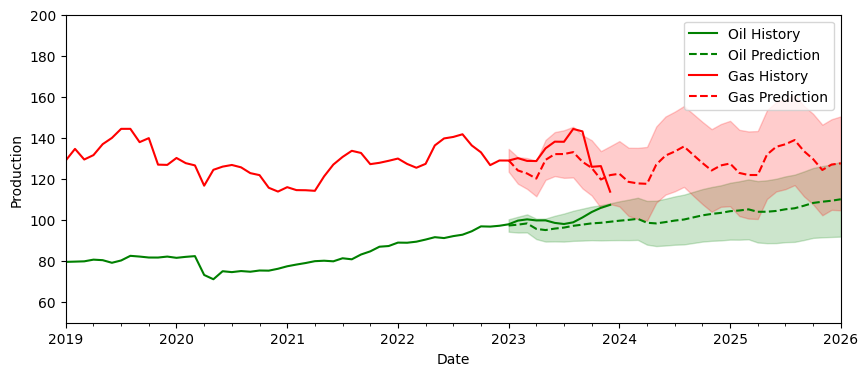

In [52]:
fig = df.loc["2019-01-01":, "produccion_petroleo_promedio_dia_km3"].plot(
    label="Oil History", figsize=(10, 4), color="green"
)
pred_oil.predicted_mean.plot(
    ax=fig, label="Oil Prediction", color="green", linestyle="--"
)
fig.fill_between(
    pred_IC_oil.index,
    pred_IC_oil.iloc[:, 0],
    pred_IC_oil.iloc[:, 1],
    color="green",
    alpha=0.2,
)
fig = df.loc["2019-01-01":, "produccion_gas_promedio_dia_Mm3"].plot(
    label="Gas History", figsize=(10, 4), color="red"
)
pred_gas.predicted_mean.plot(
    ax=fig, label="Gas Prediction", color="red", linestyle="--"
)
fig.fill_between(
    pred_IC_gas.index,
    pred_IC_gas.iloc[:, 0],
    pred_IC_gas.iloc[:, 1],
    color="red",
    alpha=0.2,
)
plt.ylabel("Production")
plt.ylim(50, 200)
plt.legend()
plt.show()

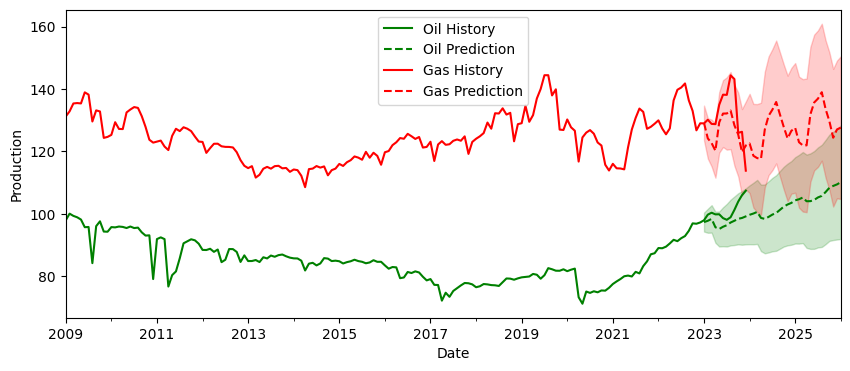

In [53]:
fig = df.loc["2009-01-01":, "produccion_petroleo_promedio_dia_km3"].plot(
    label="Oil History", figsize=(10, 4), color="green"
)
pred_oil.predicted_mean.plot(
    ax=fig, label="Oil Prediction", color="green", linestyle="--"
)
fig.fill_between(
    pred_IC_oil.index,
    pred_IC_oil.iloc[:, 0],
    pred_IC_oil.iloc[:, 1],
    color="green",
    alpha=0.2,
)

fig = df.loc["2009-01-01":, "produccion_gas_promedio_dia_Mm3"].plot(
    label="Gas History", figsize=(10, 4), color="red"
)
pred_gas.predicted_mean.plot(
    ax=fig, label="Gas Prediction", color="red", linestyle="--"
)
fig.fill_between(
    pred_IC_gas.index,
    pred_IC_gas.iloc[:, 0],
    pred_IC_gas.iloc[:, 1],
    color="red",
    alpha=0.2,
)

plt.ylabel("Production")
plt.legend()
plt.show()

In [54]:
y_pred_oil = pred_oil.predicted_mean[:12]
y_real_oil = test_oil
mse = ((y_pred_oil - y_real_oil) ** 2).mean()
print(f"El error cuadrático medio es {round(mse, 2)}")
print(f"La raiz del error cuadrático medio es {round(np.sqrt(mse), 2)}")
print(
    f"Porcentaje de error con respecto al promedio: {round(100*np.sqrt(mse)/(df['produccion_petroleo_promedio_dia_km3'].mean()), 3)} %"
)

El error cuadrático medio es 18.71
La raiz del error cuadrático medio es 4.33
Porcentaje de error con respecto al promedio: 5.037 %


In [55]:
y_pred_gas = pred_gas.predicted_mean[:12]
y_real_gas = test_gas
mse = ((y_pred_gas - y_real_gas) ** 2).mean()
print(f"El error cuadrático medio es {round(mse, 2)}")
print(f"La raiz del error cuadrático medio es {round(np.sqrt(mse), 2)}")
print(
    f"Porcentaje de error con respecto al promedio: {round(100*np.sqrt(mse)/(df['produccion_gas_promedio_dia_Mm3'].mean()), 3)} %"
)

El error cuadrático medio es 58.79
La raiz del error cuadrático medio es 7.67
Porcentaje de error con respecto al promedio: 6.139 %


### Prophet

Prophet es un procedimiento de previsión de datos de series temporales basado en un modelo aditivo en el que las tendencias no lineales se ajustan con estacionalidad anual, semanal y diaria, además de efectos de vacaciones. Funciona mejor con series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es resistente a los datos que faltan y a los cambios en la tendencia, y suele manejar bien los valores atípicos.

Prophet es un software de código abierto publicado por el equipo de ciencia de datos básicos de Facebook. Se puede descargar en CRAN y PyPI.

**Preciso y rápido:**

Prophet se utiliza en muchas aplicaciones de Facebook para elaborar previsiones fiables para la planificación y el establecimiento de objetivos. Hemos comprobado que, en la mayoría de los casos, ofrece mejores resultados que cualquier otro método. Ajustamos modelos en Stan para que obtengas previsiones en tan solo unos segundos.

**Totalmente automático:**

Obtenga una previsión razonable con datos desordenados sin esfuerzo manual. Prophet es robusto frente a valores atípicos, datos perdidos y cambios drásticos en las series temporales.

**Previsiones ajustables:**

El procedimiento Prophet incluye muchas posibilidades para que los usuarios ajusten las previsiones. Puede utilizar parámetros interpretables por el ser humano para mejorar su previsión añadiendo su conocimiento del dominio.

**Disponible en R o Python:**

Hemos implementado el procedimiento Prophet en R y Python, pero comparten el mismo código Stan subyacente para el ajuste. Utilice cualquier lenguaje con el que se sienta cómodo para obtener previsiones.

Pueden decodificar Prophet aquí: https://medium.com/@jain.sm/facebook-prophet-decoded-e7af322f56c2

In [56]:
# Convert 'date' to datetime and rename columns for Prophet
df_oil["ds"] = pd.to_datetime(df_oil["indice_tiempo"])
df_oil.rename(columns={"produccion_petroleo_promedio_dia_m3": "y"}, inplace=True)
df_gas["ds"] = pd.to_datetime(df_oil["indice_tiempo"])
df_gas.rename(columns={"produccion_gas_promedio_dia_mm3": "y"}, inplace=True)

In [57]:
df_oil

,anio,mes,indice_tiempo,y,ds
0,2009,1,2009-01,97924.5991,2009-01-01
1,2009,2,2009-02,100044.0659,2009-02-01
2,2009,3,2009-03,99329.5204,2009-03-01
3,2009,4,2009-04,98880.3859,2009-04-01
4,2009,5,2009-05,98151.9991,2009-05-01
...,...,...,...,...,...
175,2023,8,2023-08,98899.7214,2023-08-01
176,2023,9,2023-09,101249.5925,2023-09-01
177,2023,10,2023-10,103903.3087,2023-10-01
178,2023,11,2023-11,105964.1426,2023-11-01


In [58]:
df_gas

,anio,mes,indice_tiempo,y,ds
0,2009,1,2009-01,131223.0108,2009-01-01
1,2009,2,2009-02,132833.2683,2009-02-01
2,2009,3,2009-03,135361.2048,2009-03-01
3,2009,4,2009-04,135493.2462,2009-04-01
4,2009,5,2009-05,135374.4330,2009-05-01
...,...,...,...,...,...
175,2023,8,2023-08,144374.8508,2023-08-01
176,2023,9,2023-09,143185.6279,2023-09-01
177,2023,10,2023-10,125936.3690,2023-10-01
178,2023,11,2023-11,126286.3582,2023-11-01


In [59]:
# Drop the original 'date' column as it's no longer needed
df_oil.drop(columns=["anio", "mes", "indice_tiempo"], inplace=True)
df_gas.drop(columns=["anio", "mes", "indice_tiempo"], inplace=True)

In [60]:
df_oil["y"] = df_oil["y"] / 1000
df_gas["y"] = df_gas["y"] / 1000

In [61]:
df_oil

,y,ds
0,97.924599,2009-01-01
1,100.044066,2009-02-01
2,99.329520,2009-03-01
3,98.880386,2009-04-01
4,98.151999,2009-05-01
...,...,...
175,98.899721,2023-08-01
176,101.249593,2023-09-01
177,103.903309,2023-10-01
178,105.964143,2023-11-01


In [62]:
df_gas

,y,ds
0,131.223011,2009-01-01
1,132.833268,2009-02-01
2,135.361205,2009-03-01
3,135.493246,2009-04-01
4,135.374433,2009-05-01
...,...,...
175,144.374851,2023-08-01
176,143.185628,2023-09-01
177,125.936369,2023-10-01
178,126.286358,2023-11-01


In [63]:
# Initialize the Prophet model
model_oil = Prophet(yearly_seasonality=True, interval_width=0.95)
model_gas = Prophet(yearly_seasonality=True, interval_width=0.95)

# Fit the model with the oil production DataFrame
model_oil.fit(df_oil)
model_gas.fit(df_gas)

17:40:04 - cmdstanpy - INFO - Chain [1] start processing
17:40:04 - cmdstanpy - INFO - Chain [1] done processing
17:40:04 - cmdstanpy - INFO - Chain [1] start processing
17:40:04 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
# Make a future DataFrame for the next 24 months
future_oil = model_oil.make_future_dataframe(periods=24, freq="ME")
future_gas = model_gas.make_future_dataframe(periods=24, freq="ME")

In [65]:
# Predict the future oil production
forecast_oil = model_oil.predict(future_oil)
forecast_gas = model_gas.predict(future_gas)

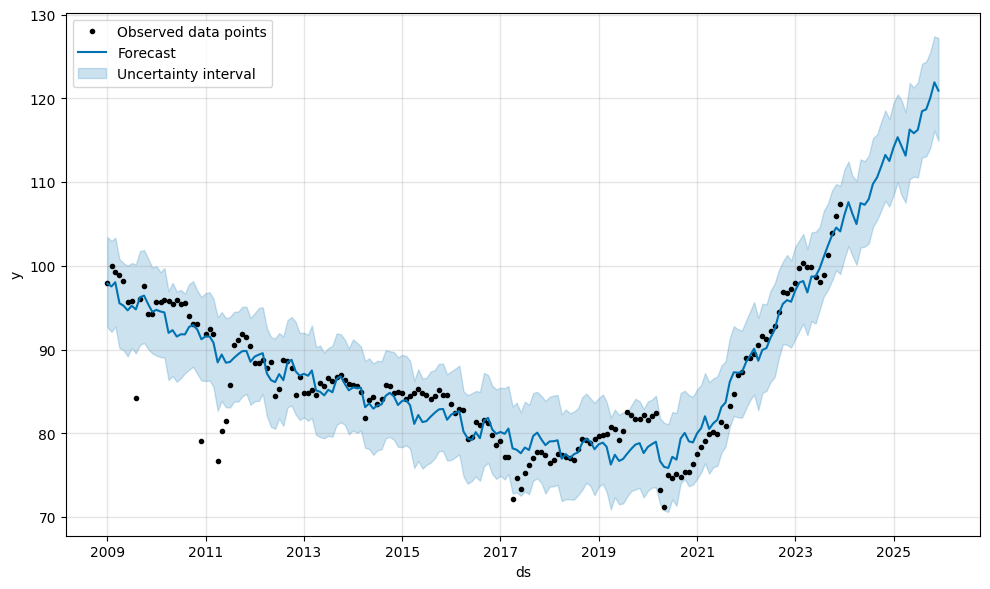

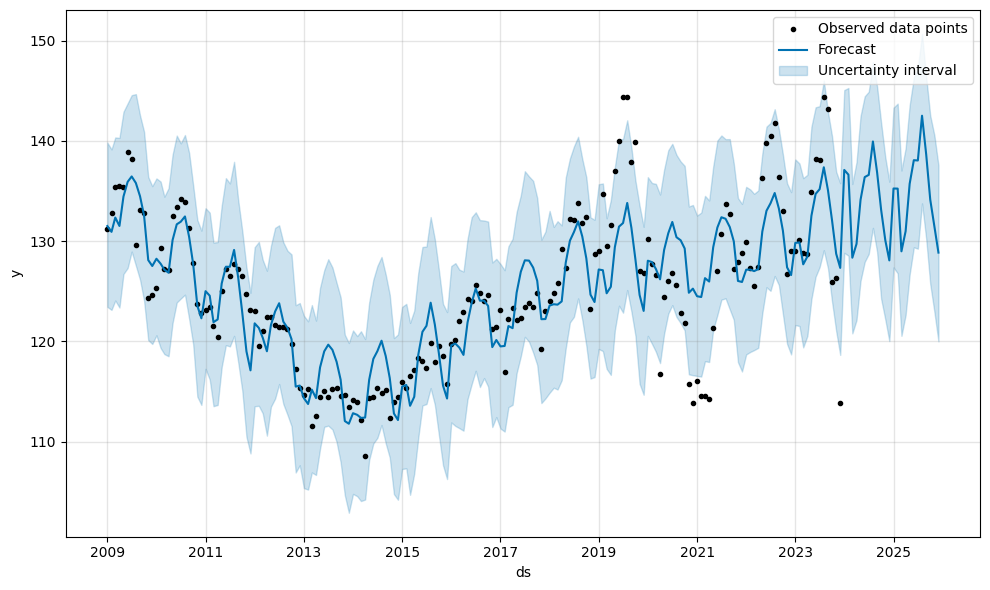

In [66]:
# Plot the forecast
fig = model_oil.plot(forecast_oil, include_legend=True)
fig = model_gas.plot(forecast_gas, include_legend=True)

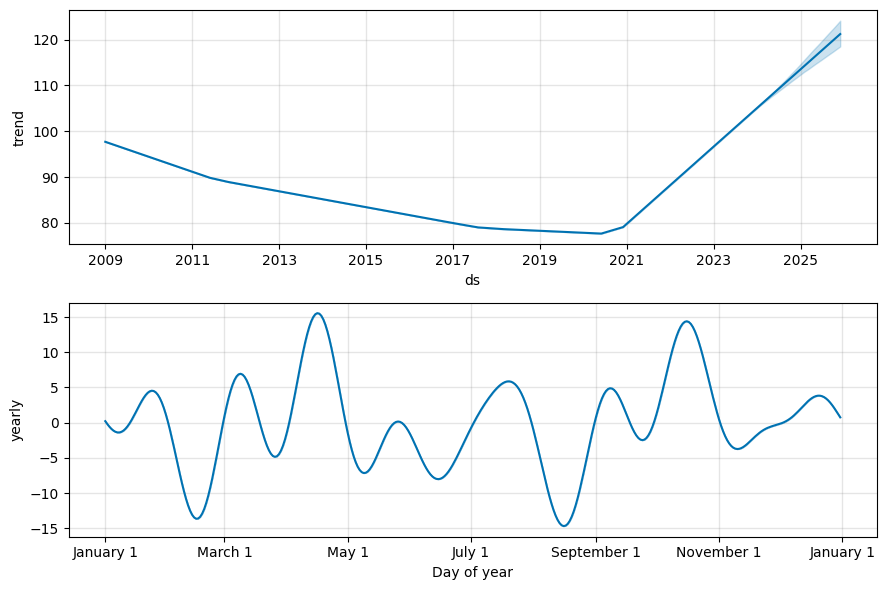

In [67]:
fig_components_oil = model_oil.plot_components(forecast_oil)

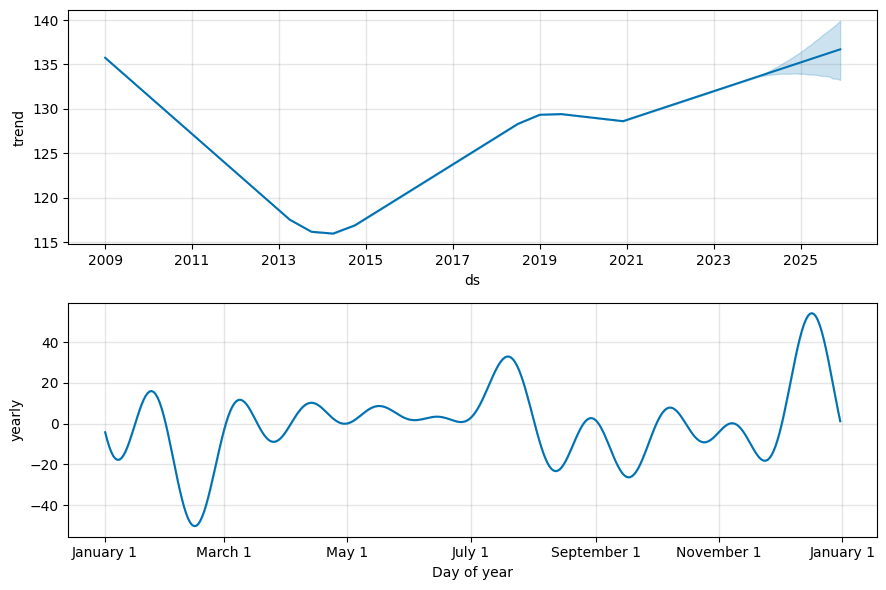

In [68]:
fig_components_gas = model_gas.plot_components(forecast_gas)

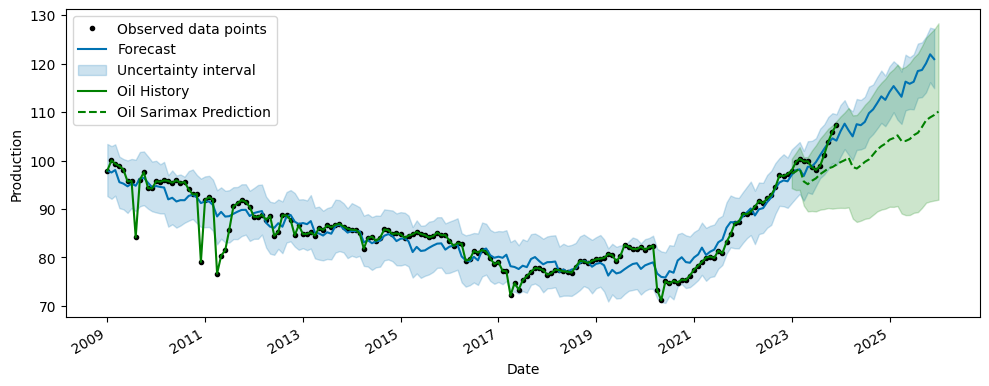

In [69]:
fig = model_oil.plot(forecast_oil, include_legend=True)
fig = df.loc["2009-01-01":, "produccion_petroleo_promedio_dia_km3"].plot(
    label="Oil History", figsize=(10, 4), color="green"
)
pred_oil.predicted_mean.plot(
    ax=fig, label="Oil Sarimax Prediction", color="green", linestyle="--"
)
fig.fill_between(
    pred_IC_oil.index,
    pred_IC_oil.iloc[:, 0],
    pred_IC_oil.iloc[:, 1],
    color="green",
    alpha=0.2,
)

plt.ylabel("Production")
plt.legend()
plt.show()

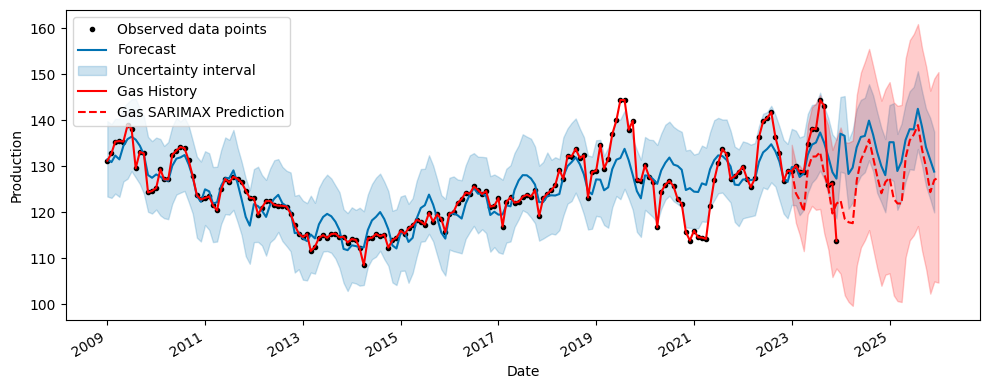

In [70]:
fig = model_gas.plot(forecast_gas, include_legend=True)
fig = df.loc["2009-01-01":, "produccion_gas_promedio_dia_Mm3"].plot(
    label="Gas History", figsize=(10, 4), color="red"
)
pred_gas.predicted_mean.plot(
    ax=fig, label="Gas SARIMAX Prediction", color="red", linestyle="--"
)
fig.fill_between(
    pred_IC_gas.index,
    pred_IC_gas.iloc[:, 0],
    pred_IC_gas.iloc[:, 1],
    color="red",
    alpha=0.2,
)
plt.ylabel("Production")
plt.legend()
plt.show()

#### Shocks o Punto de cambio

Si lo deseamos, podemos especificar manualmente las ubicaciones de posibles puntos de cambio con el argumento **changepoints**. 

Los puntos de cambio podrían limitarse por completo a un pequeño conjunto de fechas, como se hace aquí:

In [71]:
cp = [
    "2011-11-01",
    "2015-11-01",
    "2019-11-01",
    "2020-03-01",
    "2023-11-01",
]  # COVID y Elecciones Presidenciales

In [72]:
model_oil_cp = Prophet(yearly_seasonality=True, interval_width=0.95, changepoints=cp)
model_gas_cp = Prophet(yearly_seasonality=True, interval_width=0.95, changepoints=cp)

In [73]:
model_oil_cp.fit(df_oil)
model_gas_cp.fit(df_gas)

17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing
17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
future_oil_cp = model_oil_cp.make_future_dataframe(periods=24, freq="ME")
future_gas_cp = model_gas_cp.make_future_dataframe(periods=24, freq="ME")
forecast_oil_cp = model_oil_cp.predict(future_oil_cp)
forecast_gas_cp = model_gas_cp.predict(future_gas_cp)

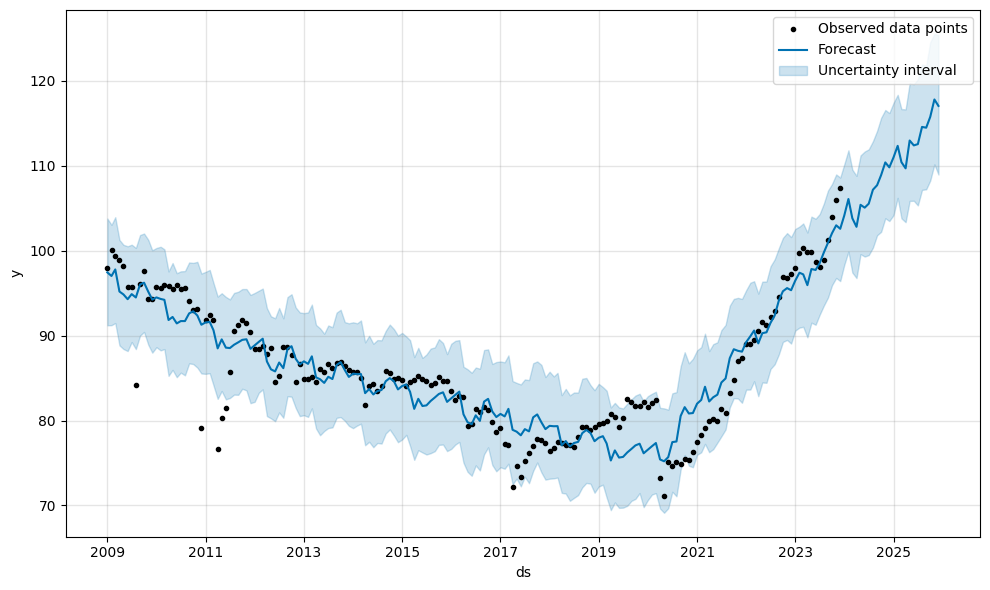

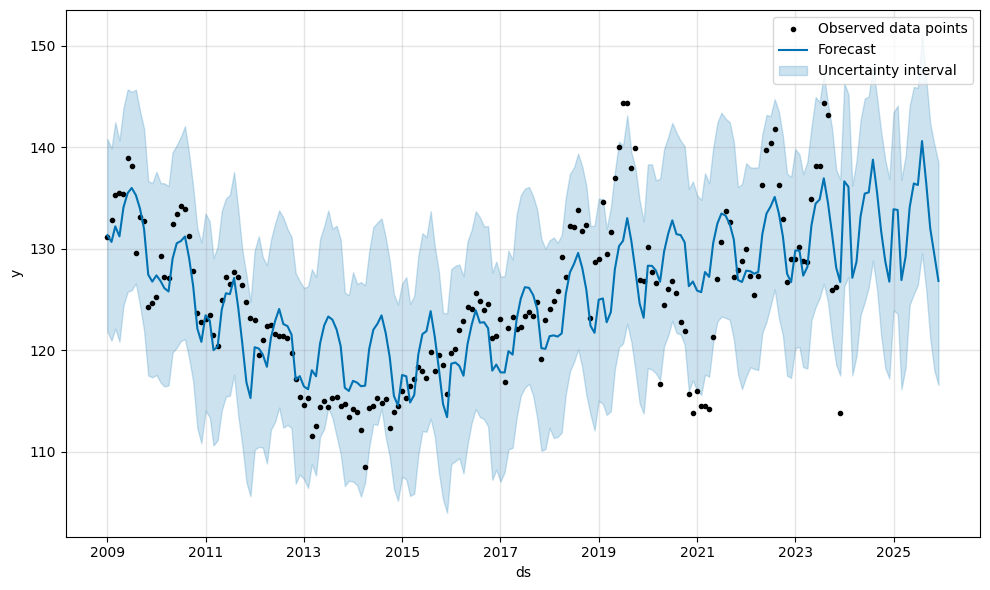

In [75]:
fig = model_oil_cp.plot(forecast_oil_cp, include_legend=True)
fig = model_gas_cp.plot(forecast_gas_cp, include_legend=True)

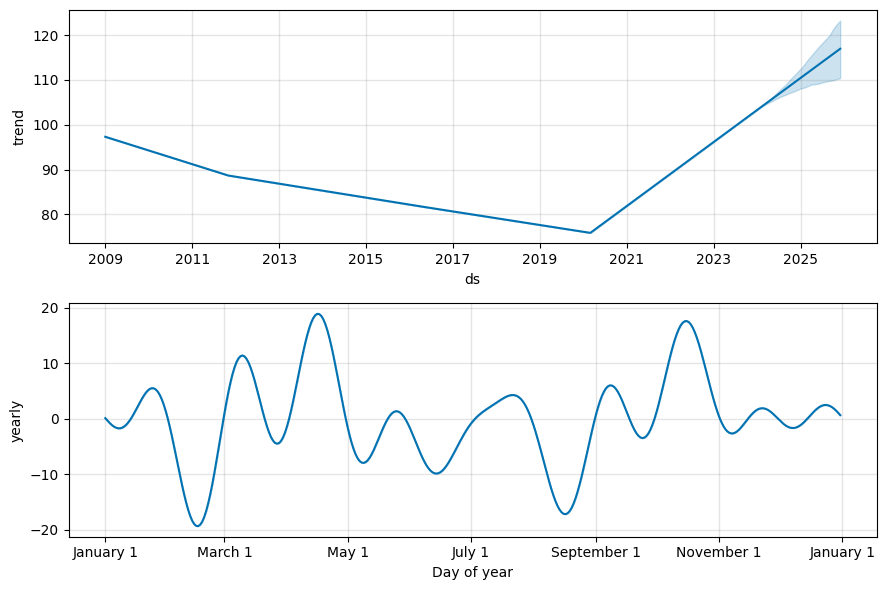

In [76]:
fig_components_oil_cp = model_oil_cp.plot_components(forecast_oil_cp)

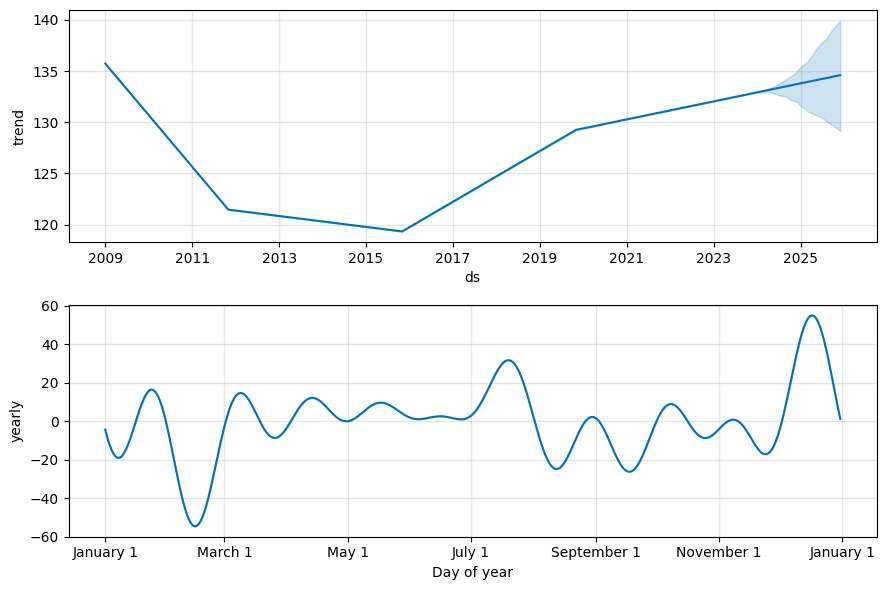

In [77]:
fig_components_gas_cp = model_gas_cp.plot_components(forecast_gas_cp)

Podemos detectarlos automaticamente sobre los modelos originales también:

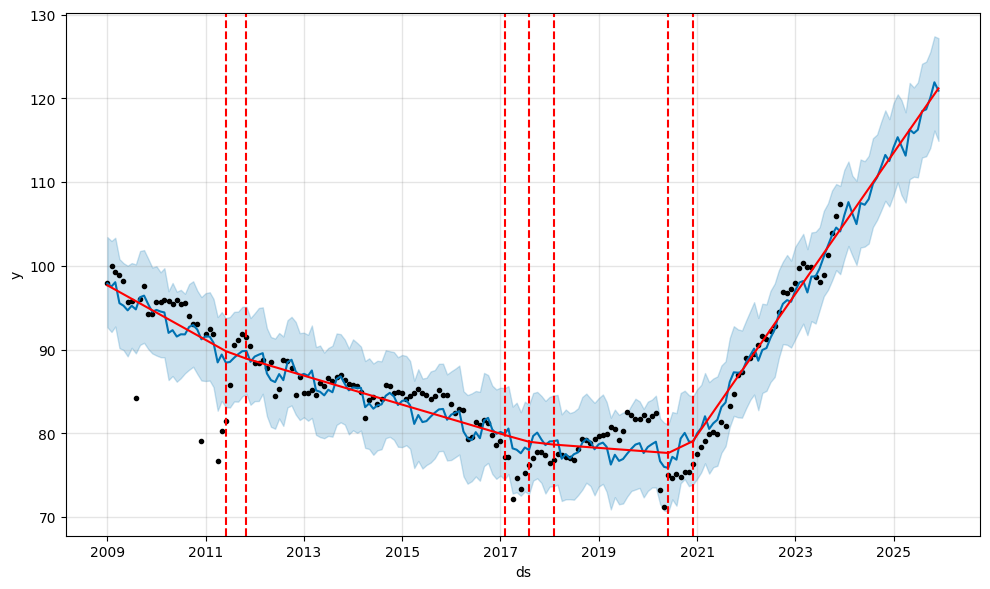

In [78]:
fig_aut = model_oil.plot(forecast_oil)
o_out = add_changepoints_to_plot(fig_aut.gca(), model_oil, forecast_oil)

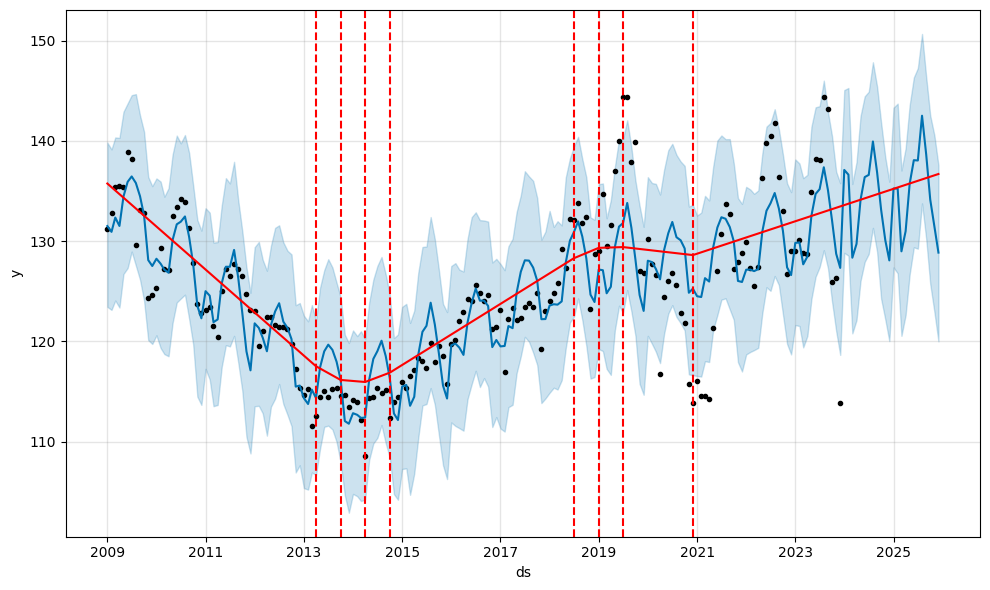

In [79]:
fig_aut = model_gas.plot(forecast_gas)
g_out = add_changepoints_to_plot(fig_aut.gca(), model_gas, forecast_gas)

### LSTM (Long-Short Term Memory)

**¿Por qué LSTM?**

Las redes LSTM están diseñadas específicamente para resolver las limitaciones de las RNN tradicionales a la hora de captar dependencias a largo plazo. Son capaces de aprender y recordar secuencias largas, lo que las hace ideales para la predicción de series temporales. A continuación se explica por qué las LSTM son una buena opción:

* Células de memoria: Las redes LSTM utilizan células de memoria para almacenar información durante largos periodos de tiempo.
* Mecanismos de compuerta: Las redes LSTM tienen puertas (de entrada, olvido y salida) que controlan el flujo de información, lo que les permite retener la información relevante y descartar la que no es necesaria.
* Gestión de gradientes de fuga (Vanishing Gradients): La arquitectura de las LSTM mitiga el problema del gradiente de fuga, lo que permite el aprendizaje de dependencias a largo plazo.

In [80]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import MinMaxScaler

In [81]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

In [82]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        # LSTM Layer
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, batch_first=True, bidirectional=bidirectional
        )
        if not self.bidirectional:
        # Fully connected layer
             self.linear = nn.Linear(hidden_dim, output_dim)
        elif self.bidirectional:
             self.linear = nn.Linear(2*hidden_dim, output_dim)
           

    def forward(self, x):
        self.lstm.flatten_parameters()
        out, (hn, cn) = self.lstm(x)
        out = self.linear(out)
        return out
    
    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

In [83]:
def create_sequences(dataframe, seq_length, fluid):
    if fluid == "oil":
        data = dataframe["produccion_petroleo_promedio_dia_km3"].values
    elif fluid == "gas":
        data = dataframe["produccion_gas_promedio_dia_Mm3"].values
    # Pad the beginning of the series with zeros
    first_value = data[0]
    padded_data = np.pad(data, (seq_length, 0), 'constant', constant_values=first_value)
    xs = []
    ys = []
    for i in range(len(padded_data) - seq_length):
        x = padded_data[i : (i + seq_length)]
        y = padded_data[i + seq_length]
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)

In [84]:
df

,anio,mes,indice_tiempo,produccion_petroleo_promedio_dia_m3,produccion_gas_promedio_dia_mm3,produccion_petroleo_promedio_dia_km3,produccion_gas_promedio_dia_Mm3,1a_diffoil
Date,,,,,,,,
2009-01-01,2009,1,2009-01,97924.5991,131223.0108,97.924599,131.223011,NaN
2009-02-01,2009,2,2009-02,100044.0659,132833.2683,100.044066,132.833268,2.119467
2009-03-01,2009,3,2009-03,99329.5204,135361.2048,99.329520,135.361205,-0.714546
2009-04-01,2009,4,2009-04,98880.3859,135493.2462,98.880386,135.493246,-0.449134
2009-05-01,2009,5,2009-05,98151.9991,135374.4330,98.151999,135.374433,-0.728387
...,...,...,...,...,...,...,...,...
2023-08-01,2023,8,2023-08,98899.7214,144374.8508,98.899721,144.374851,0.825982
2023-09-01,2023,9,2023-09,101249.5925,143185.6279,101.249593,143.185628,2.349871
2023-10-01,2023,10,2023-10,103903.3087,125936.3690,103.903309,125.936369,2.653716


In [85]:
df_lstm = df.drop(
    [
        "anio",
        "mes",
        "indice_tiempo",
        "produccion_petroleo_promedio_dia_m3",
        "produccion_gas_promedio_dia_mm3",
        '1a_diffoil'
    ],
    axis=1,
)

In [86]:
df_lstm

,produccion_petroleo_promedio_dia_km3,produccion_gas_promedio_dia_Mm3
Date,,
2009-01-01,97.924599,131.223011
2009-02-01,100.044066,132.833268
2009-03-01,99.329520,135.361205
2009-04-01,98.880386,135.493246
2009-05-01,98.151999,135.374433
...,...,...
2023-08-01,98.899721,144.374851
2023-09-01,101.249593,143.185628
2023-10-01,103.903309,125.936369


In [87]:
minmax = MinMaxScaler()
scaled_df = minmax.fit_transform(df_lstm)

In [88]:
scaled_df = pd.DataFrame(
    scaled_df,
    columns=["produccion_petroleo_promedio_dia_km3", "produccion_gas_promedio_dia_Mm3"],
)

In [89]:
scaled_df

,produccion_petroleo_promedio_dia_km3,produccion_gas_promedio_dia_Mm3
0,0.738519,0.632197
1,0.797031,0.677066
2,0.777305,0.747505
3,0.764906,0.751184
4,0.744797,0.747873
...,...,...
175,0.765439,0.998664
176,0.830312,0.965527
177,0.903572,0.484889
178,0.960465,0.494641


In [90]:
# Parámetros
SEQ_LENGTH = 2
HIDDEN_DIM = SEQ_LENGTH * 32
OUTPUT_DIM = 1
BATCH_SIZE = 1
LR = 0.001
EPOCHS = 25
BD = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [91]:
X_oil, y_oil = create_sequences(scaled_df, SEQ_LENGTH, "oil")
X_oil_train = torch.tensor(X_oil).float()
y_oil_train = torch.tensor(y_oil).float()

In [92]:
train_oil_data = TensorDataset(X_oil_train, y_oil_train)
train_oil_loader = DataLoader(train_oil_data, batch_size=BATCH_SIZE, shuffle=False)

In [93]:
model = LSTMModel(
    input_dim=SEQ_LENGTH, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, bidirectional=BD
)

In [94]:
model.reset_parameters()
model.train().to(DEVICE)

LSTMModel(
  (lstm): LSTM(2, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [95]:
criterion = nn.MSELoss().to(DEVICE)
optimizer = torch.optim.Adam(
    model.parameters(), lr=LR, amsgrad=True, weight_decay=LR * 0.1
)

In [96]:
total_oil_loss = []
scaler = GradScaler()  # Initialize the gradient scaler
for epoch in range(EPOCHS):
    for seq, labels in train_oil_loader:
        optimizer.zero_grad()
        seq, labels = (
            seq.to(DEVICE),
            labels.to(DEVICE),
        )
        # Forward pass with autocast
        with autocast():
            y_pred = model(seq)
            loss = criterion(y_pred, labels)
        # Backpropagation with automatic mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    total_oil_loss.append(loss.item())
    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch} Loss: {loss.item()}")

Epoch 0 Loss: 0.17144775390625
Epoch 10 Loss: 0.006257057189941406
Epoch 20 Loss: 0.005654335021972656
Epoch 24 Loss: 0.0060274600982666016


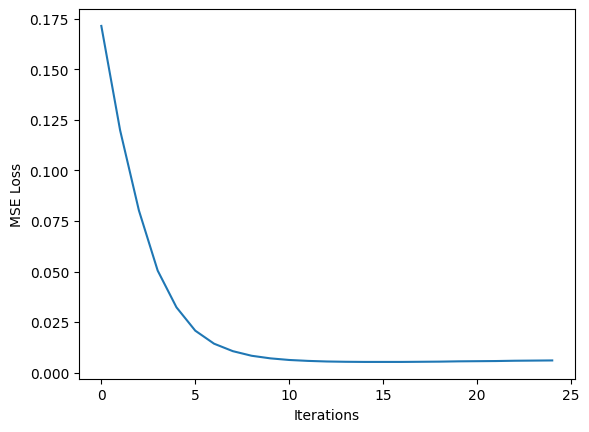

In [97]:
plt.plot(total_oil_loss)
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.show()

In [98]:
oil_predictions = []
loss_oil_predictions = []
model.eval()
with torch.no_grad():
    for seq, labels in train_oil_loader:
        seq, labels = (
            seq.to(DEVICE),
            labels.to(DEVICE),
        )
        with autocast():
            y_pred = model(seq)
            loss = criterion(y_pred, labels)
        oil_predictions.append(y_pred.cpu().numpy())
        loss_oil_predictions.append(loss.cpu().numpy())

In [99]:
np.mean(loss_oil_predictions)

0.012043664

In [100]:
flattened_oil_list = [element for array in oil_predictions for element in array.flatten()]

In [101]:
X_gas, y_gas = create_sequences(scaled_df, SEQ_LENGTH, "gas")
X_gas_train = torch.tensor(X_gas).float()
y_gas_train = torch.tensor(y_gas).float()
train_gas_data = TensorDataset(X_gas_train, y_gas_train)
train_gas_loader = DataLoader(train_gas_data, batch_size=BATCH_SIZE, shuffle=False)

In [102]:
model.reset_parameters()
model.train().to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
optimizer = torch.optim.Adam(
    model.parameters(), lr=LR, amsgrad=True, weight_decay=LR * 0.1
)

In [103]:
total_gas_loss = []
scaler = GradScaler()  # Initialize the gradient scaler
for epoch in range(EPOCHS):
    for seq, labels in train_gas_loader:
        optimizer.zero_grad()
        seq, labels = (
            seq.to(DEVICE),
            labels.to(DEVICE),
        )
        # Forward pass with autocast
        with autocast():
            y_pred = model(seq)
            loss = criterion(y_pred, labels)
        # Backpropagation with automatic mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    total_gas_loss.append(loss.item())
    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch} Loss: {loss.item()}")

Epoch 0 Loss: 0.1968926042318344
Epoch 10 Loss: 0.15594419836997986
Epoch 20 Loss: 0.15478941798210144
Epoch 24 Loss: 0.1540219485759735


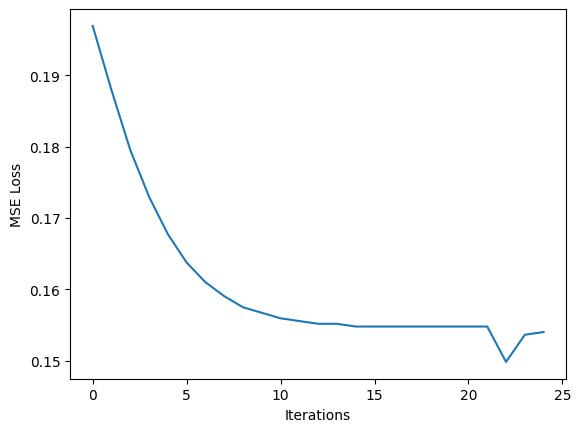

In [104]:
plt.plot(total_gas_loss)
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.show()

In [105]:
gas_predictions = []
loss_gas_predictions = []
model.eval()
with torch.no_grad():
    for seq, labels in train_gas_loader:
        seq, labels = (
            seq.to(DEVICE),
            labels.to(DEVICE),
        )
        with autocast():
            y_pred = model(seq)
            loss = criterion(y_pred, labels)
        gas_predictions.append(y_pred.cpu().numpy())
        loss_gas_predictions.append(loss.cpu().numpy())

In [106]:
np.mean(loss_gas_predictions)

0.012620423

In [107]:
flattened_gas_list = [element for array in gas_predictions for element in array.flatten()]

In [108]:
oil_series = pd.Series(flattened_oil_list)
gas_series = pd.Series(flattened_gas_list)

In [109]:
pred_scaled_df = pd.concat([oil_series, gas_series], axis=1)
pred_scaled_df.columns = ["prediccion_produccion_petroleo_promedio_dia_km3", "prediccion_produccion_gas_promedio_dia_Mm3"]

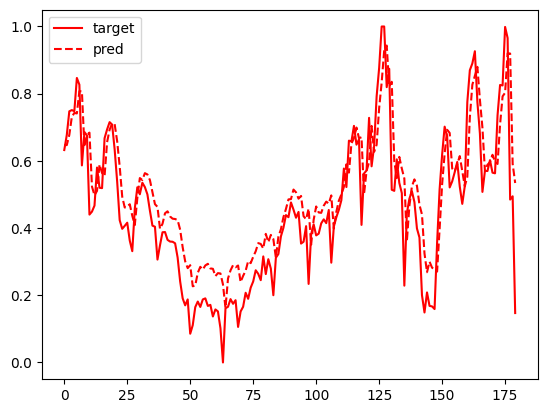

In [110]:
plt.plot(scaled_df['produccion_gas_promedio_dia_Mm3'], color='red', label='target')
plt.plot(pred_scaled_df['prediccion_produccion_gas_promedio_dia_Mm3'], color='red', linestyle='--', label='pred')
plt.legend()
plt.show()

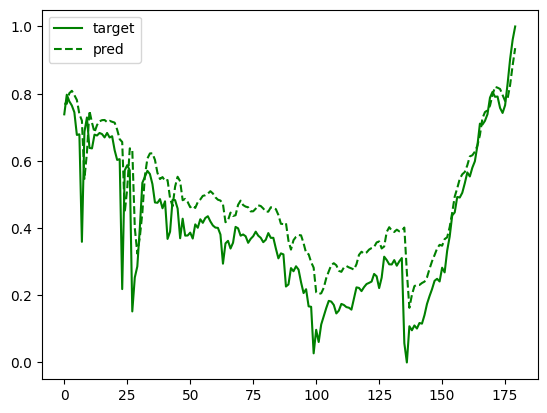

In [111]:
plt.plot(scaled_df['produccion_petroleo_promedio_dia_km3'], color='green', label='target')
plt.plot(pred_scaled_df['prediccion_produccion_petroleo_promedio_dia_km3'], color='green', linestyle='--', label='pred')
plt.legend()
plt.show()

**Ejercicio:** Mejorar las preddiciones hechas por la red LSTM

**Entendiendo los Fundamentos**

* ¿Qué es SARIMAX y cómo extiende el modelo ARIMA?
* ¿Qué es Prophet y qué lo distingue de los modelos tradicionales de series de tiempo como SARIMAX?
* ¿Qué es LSTM y cómo se utiliza para el pronóstico de series temporales?

**Componentes y Características del Modelo**

* ¿Cómo maneja SARIMAX la estacionalidad en los datos de series de tiempo? 
* ¿Cómo maneja Prophet la estacionalidad y qué opciones proporciona para modelar diferentes estacionalidades?
* ¿Cómo maneja LSTM la estacionalidad en los datos de series temporales?

**Variables Exógenas y Regresores**

* ¿Qué papel juegan las variables exógenas en SARIMAX y en qué se diferencian de los regresores en Prophet?
* ¿Cómo se integran las variables adicionales en LSTM para mejorar las predicciones de series temporales?

**Ajuste del Modelo y Predicción**

* ¿En qué se diferencian SARIMAX y Prophet en términos de ajuste del modelo y selección de parámetros?
* Discuta la flexibilidad de SARIMAX y Prophet para manejar datos faltantes y valores atípicos.
* ¿Cómo manejan los modelos LSTM datos faltantes y valores atípicos en series temporales?


**Consideraciones Prácticas**

* ¿Qué escenarios son más adecuados para SARIMAX versus Prophet, considerando factores como la estacionalidad de los datos, conocimiento del dominio y recursos computacionales?
* ¿Cómo se desempeñan SARIMAX y Prophet en términos de eficiencia computacional y escalabilidad con grandes conjuntos de datos?     
* ¿Qué desafíos podrías enfrentar al implementar SARIMAX y Prophet para problemas de pronóstico en el mundo real?
* ¿Qué escenarios son más adecuados para LSTM en comparación con SARIMAX y Prophet?
* ¿Cómo se desempeñan LSTM en términos de eficiencia computacional y escalabilidad con grandes conjuntos de datos?
* ¿Qué desafíos podrías enfrentar al implementar LSTM para problemas de pronóstico en el mundo real?


![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)